# ベースモデル


## 5/11 1500: validation loss = 0.31292   validation accuracy = 0.86842
StratifiedGraoupKfoldで安定的なCVの作成
```
self.fold 3
epoch 1~5
```

## base_v0511-1600  validation loss = 0.29827   validation accuracy = 0.87642
```
self.fold_num = 3
self.model_arch= "dm_nfnet_f0"
val_epochs :  [1, 1, 0]
```


## 5/12 0710  validation loss = 0.23662   validation accuracy = 0.91820
val_epochs :  [1, 1, 2, 0, 1]


In [1]:
#ColaboratoryかKaggleNotebookか判別
import sys
import os
from pathlib import Path

WORKING_DIR = '/content/drive/MyDrive/git/kaggle-inclass-brest-cancer-classification/working'  # コンペごとに書き換える
MAIN_INPUT_NAME = "brest-cancer-classification"     # コンペごとに書き換える

INPUT = Path('../input/')
MAIN_INPUT_ZIP = f'../input/{MAIN_INPUT_NAME}.zip'
if 'google.colab' in sys.modules:  # colab環境
    INPUT = Path('/content/input/')

    # drive mount
    from google.colab import drive
    drive.mount('/content/drive/')

    # working dir に移動
    os.chdir(WORKING_DIR)
    print("cwd:", os.getcwd())

    if not os.path.exists("/content/input"):
        # 必要な input を指定先へ unzip
        !unzip -q {MAIN_INPUT_ZIP} -d {INPUT}
        print("unzip INPUT")
    
elif 'kaggle_web_client' in sys.modules:  # kaggle環境
    pass

!pip install timm
!pip install albumentations==0.4.5
!pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn==1.0.dev0

Mounted at /content/drive/
cwd: /content/drive/MyDrive/git/kaggle-inclass-brest-cancer-classification/working
unzip INPUT
     |████████████████████████████████| 296kB 7.2MB/s 
     |████████████████████████████████| 122kB 8.3MB/s 
     |████████████████████████████████| 634kB 54.1MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.5-cp37-none-any.whl size=64378 sha256=427c9297746cd664ee4f05d974332cbb363114e2c1b58dda9eb008b55868d87c
  Stored in directory: /root/.cache/pip/wheels/f0/a0/61/e50f93165a5ec7e7f5d65064e513239505bc4c06d2289557d3
  Created wheel for imgaug: filename=imgaug-0.2.6-cp37-none-any.whl size=654019 sha256=6d1d6180cd3502977a2574e4e3fc1f2673be39377a083b249f0c7477ea761341
  Stored in directory: /root/.cache/pip/wheels/97/ec/48/0d25896c417b715af6236dbcef8f0bed136a1a5e52972fc6d0
Successfully built albumentations imgaug
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Found existing in

In [2]:
!nvidia-smi

Sun May 16 11:22:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## ライブラリ

In [3]:
import json
import os
import random
import time

import numpy as np
import pandas as pd
import cv2

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.cuda.amp import autocast, GradScaler

import timm
from tqdm.notebook import tqdm

from sklearn.model_selection import StratifiedKFold, GroupKFold, StratifiedGroupKFold
from sklearn.metrics import log_loss, f1_score

#最大表示列数の指定（ここでは50列を指定）
pd.set_option('display.max_columns', 50)

#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 100)

In [ ]:
timm.list_models("*nfnet*",pretrained=True)

['dm_nfnet_f0',
 'dm_nfnet_f1',
 'dm_nfnet_f2',
 'dm_nfnet_f3',
 'dm_nfnet_f4',
 'dm_nfnet_f5',
 'dm_nfnet_f6',
 'nfnet_l0c']

## 設定

In [5]:
class Config:
    def __init__(self, debug:bool):
        self.debug = debug 
        self.suffix = "_debug" if self.debug else ""
        self.data_directory = "./data"
        self.seed = 42
        self.num_concat=1 # 縦横何ます増やす？
        self.preprocess = False

        self.fold_num = 5
        self.model_arch= "dm_nfnet_f0"
        self.model_shape = "head.fc"
        self.img_size_h= 150
        self.img_size_w= 150
        self.epochs = 2
        self.train_bs = 256
        self.valid_bs = 256
        self.T_0 = 10
        self.one_size = (50,50)
        self.lr = 3e-4
        self.min_lr = 3e-6
        self.weight_decay = 2e-5
        self.num_workers = 4
        self.verbose_step = 1
        self.tta = 3
        self.monitor = "val_accuracy"
        self.patience = 1 # for EarlyStopping
        self.mode = "max"
        self.psudo = False
        self.device = "cuda:0"

config = Config(debug=False)
os.makedirs(config.data_directory, exist_ok=True)

## 便利関数

# データセット

In [ ]:
'''
class BreastDataset(Dataset):
    def __init__(self, df, transforms=None, output_label=True):
        super().__init__()
        self.df = df.copy()
        self.transforms = transforms
        self.output_label = output_label

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):
        if self.output_label:
            target = self.df["label"][index]

        img  = get_img(self.df.loc[index]["img_path"])

        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.output_label:
            return img, target
        else:
            return img
'''



class BreastDataset(Dataset):
    def __init__(self, df, transforms=None, output_label=True):
        super().__init__()
        self.df = df.copy()
        self.transforms = transforms
        self.output_label = output_label

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index: int):

        
        if self.output_label:
            target = self.df["label"][index]

        img  = get_img_concat(config.num_concat, self.df.loc[index]["type"], self.df.loc[index]["exam"], self.df.loc[index]["x"], self.df.loc[index]["y"], self.df.loc[index]["label"]) #  label は存在しない場合(test)で使わない

        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.output_label:
            return img, target
        else:
            return img



def prepare_dataloader(df, input_shape, trn_idx, val_idx, train_bs, valid_bs, num_workers):
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)

    train_ds = BreastDataset(train_, transforms=get_train_transforms(input_shape), output_label=True)
    valid_ds = BreastDataset(valid_, transforms=get_valid_transforms(input_shape), output_label=True)

    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=train_bs,
        pin_memory=True, # faster and use memory
        drop_last=False,
        shuffle=True,
        num_workers=num_workers,
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds,
        batch_size=valid_bs,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=True,
    )
    return train_loader, val_loader

# data augumentation

In [ ]:
from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize,ToGray
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms(input_shape):
    return Compose([
            Resize(input_shape[0], input_shape[1]),
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            #ShiftScaleRotate(p=0.5),
            Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
            ToTensorV2(p=1.0),
        ], p=1.)

def get_valid_transforms(input_shape):
    return Compose([
                Resize(input_shape[0], input_shape[1]),
                Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
                ToTensorV2(p=1.0),
            ], p=1.)

def get_inference_transforms(input_shape):
    return Compose([
                Resize(input_shape[0], input_shape[1]),
                #ShiftScaleRotate(p=0.5),
                ToTensorV2(p=1.0),
            ], p=1.)

# モデル

In [ ]:
class BreastClassifier(nn.Module):
    def __init__(self, model_arch, n_class, model_shape, pretrained=True):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)

        if model_shape == "classifier":
            n_features = self.model.classifier.in_features
            self.model.classifier = nn.Linear(n_features, n_class)
        elif model_shape == "head":
            n_features = self.model.head.in_features
            self.model.head = nn.Linear(n_features, n_class)
        elif model_shape == "fc":
            n_features = self.model.fc.in_features
            self.model.fc = nn.Linear(n_features, n_class)
        elif model_shape == "head.fc":
            n_features = self.model.head.fc.in_features
            self.model.head.fc = nn.Linear(n_features, n_class)

    def forward(self, x):
        x = self.model(x)
        return x

# 学習用

In [ ]:
class EarlyStopping:
    def __init__(self, patience):
        self.max_val_monitor = 1000
        self.min_val_monitor = -1000
        self.val_epoch = -1
        self.stop_count = 0
        self.patience = patience
        self.min_delta = 0

    # mode = "min" or "max"(val_loss, (val_accuracy, val_f1score))
    def update(self, monitor, epoch, mode):
        if mode == "max":
            if monitor > self.min_val_monitor:
                self.min_val_monitor = monitor
                self.val_epoch = epoch
                self.stop_count = 0
            else:
                self.stop_count+=1
        else:
            if monitor < self.max_val_monitor:
                self.max_val_monitor = monitor
                self.val_epoch = epoch
                self.stop_count = 0
            else:
                self.stop_count+=1

        if self.stop_count >= self.patience:
            return -1
        else:
            return 0


def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, verbose_step, scheduler=None, schd_batch_update=False):
    model.train()
    scaler = GradScaler()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        with autocast():
            image_preds = model(imgs)
            loss = loss_fn(image_preds, image_labels)

            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            if scheduler is not None and schd_batch_update:
                scheduler.step()

            if ((step + 1) % verbose_step == 0) or ((step + 1) == len(train_loader)):
                description = f'train epoch {epoch} loss: {running_loss:.4f}'
                pbar.set_description(description)

    #print("train: "+ description)
    if scheduler is not None and not schd_batch_update:
        scheduler.step()

def valid_one_epoch(epoch, model, loss_fn, val_loader, device, verbose_step, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []

    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        image_preds = model(imgs)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]

        loss = loss_fn(image_preds, image_labels)

        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]

        if ((step + 1) % verbose_step== 0) or ((step + 1) == len(val_loader)):
            description = f'valid epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)

    #print("valid "+ description)
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))

    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

    monitor = {}
    monitor["val_loss"] = loss_sum/sample_num
    monitor["val_accuracy"] = (image_preds_all==image_targets_all).mean()
    monitor["val_f1_score"] = f1_score(image_preds_all, image_targets_all)

    return monitor

def inference_one_epoch(model, data_loader, device):
    model.eval()
    image_preds_all = []
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()

        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]

    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

# main


In [ ]:
# train load

def load_train_df():
    base_path = os.path.join(INPUT, "train_image")
    df = pd.read_csv(os.path.join(INPUT, "train.csv"), index_col=0)
    df = pd.concat(
        [
          df,
          df['img_name'].str.rstrip(".png").str.split('_', expand=True).rename(columns={0: 'exam', 1: 'x', 2: 'y'}, inplace=False)
        ],
        axis=1
    )
    df["exam"] = df["exam"].astype(int)
    df["x"] = df["x"].str.lstrip("x_").astype(int)
    df["y"] = df["y"].str.lstrip("y_").astype(int)
    df["img_path"] = base_path + "/" + df["label"].astype(str).str.cat(df['img_name'], sep=os.sep)
    df["type"] = "train"
    return df
train_df = load_train_df()
print(train_df.shape)
train_df.head()

(175889, 7)


,img_name,label,exam,x,y,img_path,type
0,8863_x2301_y1751.png,0,8863,2301,1751,/content/input/train_image/0/8863_x2301_y1751.png,train
1,8863_x1601_y751.png,0,8863,1601,751,/content/input/train_image/0/8863_x1601_y751.png,train
2,8863_x901_y1401.png,0,8863,901,1401,/content/input/train_image/0/8863_x901_y1401.png,train
3,8863_x651_y1101.png,0,8863,651,1101,/content/input/train_image/0/8863_x651_y1101.png,train
4,8863_x351_y651.png,0,8863,351,651,/content/input/train_image/0/8863_x351_y651.png,train


In [ ]:
def load_test_df():
    base_path = os.path.join(INPUT, "test_image/test_image")
    df = pd.read_csv(os.path.join(INPUT, "submission.csv"))
    df = pd.concat(
        [
          df,
          df['Id'].str.rstrip(".png").str.split('_', expand=True).rename(columns={0: 'exam', 1: 'x', 2: 'y'}, inplace=False)
        ],
        axis=1
    )
    df["exam"] = df["exam"].astype(int)
    df["x"] = df["x"].str.lstrip("x_").astype(int)
    df["y"] = df["y"].str.lstrip("y_").astype(int)
    df["img_path"] = base_path + "/" +  df['Id']
    df["type"] = "test"
    return df

test_df = load_test_df()
print(test_df.shape)
test_df.head()

(101635, 7)


,Id,label,exam,x,y,img_path,type
0,9381_x951_y601.png,0,9381,951,601,/content/input/test_image/test_image/9381_x951_y601.png,test
1,9381_x951_y2651.png,0,9381,951,2651,/content/input/test_image/test_image/9381_x951_y2651.png,test
2,9381_x951_y2001.png,0,9381,951,2001,/content/input/test_image/test_image/9381_x951_y2001.png,test
3,9381_x951_y1951.png,0,9381,951,1951,/content/input/test_image/test_image/9381_x951_y1951.png,test
4,9381_x951_y1901.png,0,9381,951,1901,/content/input/test_image/test_image/9381_x951_y1901.png,test


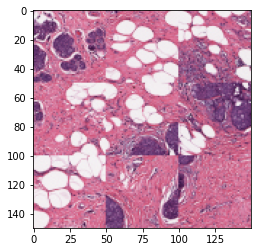

In [61]:
def seed_everything(seed):
    "seed値を一括指定"
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


def get_img(path):
    """
    pathからimageの配列を得る
    """
    im_bgr = cv2.imread(path)
    if im_bgr is None:
        print(path)
    im_rgb = im_bgr[:, :, ::-1]
    return im_rgb


  
def get_img_concat(n, datatype, exam, x, y, label=0):
    """
    3*3 の画像を作る
    /content/input/train_image/0/8863_x2301_y1751.png
    /content/input/test_image/test_image/9381_x951_y601.png
    """
    def concat_tile(im_list_2d):
        return 

    concat_path = f"/content/brest/{exam}_x{int(x)}_y{int(y)}_concat{n}.png"
    if os.path.exists(concat_path):
        im_bgr = cv2.imread(concat_path)
        im_bgr = cv2.resize(im_bgr, config.one_size)
        im_rgb = im_bgr[:, :, ::-1].astype(np.uint8)
        return im_rgb

    image_list = []
    
    diff = config.one_size[0]
    for row in range(-n, n+1, 1):  # range(n, -1-n, -1):
        row_list = []
        for col in range(-n, n+1, 1):
            base_path = f"/content/input/train_image/{label}/" if datatype=="train" else "/content/input/test_image/test_image/"
            path = base_path + f"{exam}_x{int(x+row*diff)}_y{int(y+col*diff)}.png"
            im_bgr = cv2.imread(path)
            if im_bgr is None: # 存在しない時
                im_bgr = np.zeros((diff,diff,3))
                if row==0 and col==0:
                    print(path)
            im_bgr = cv2.resize(im_bgr, config.one_size)
            im_rgb = im_bgr[:, :, ::-1].astype(np.uint8)
            row_list.append(im_rgb)
        image_list.append(row_list)
    im_tile = cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in image_list])
    return im_tile

def preprocess_concat_img(n,df, dir):
    os.makedirs(dir, exist_ok=True)
    datatype_np = df["type"].values
    exam_np = df["exam"].values
    x_np = df["x"].values
    y_np = df["y"].values
    label_np = df["label"].values
    for i in tqdm(range(len(df))):
        im_rgb = get_img_concat(n, datatype_np[i], exam_np[i], x_np[i], y_np[i], label=label_np[i])
        im_bgr = im_rgb[:, :, ::-1].astype(np.uint8)
        concat_path = dir + f"/{exam_np[i]}_x{int(x_np[i])}_y{int(y_np[i])}_concat{n}.png"
        cv2.imwrite(concat_path,im_bgr)


if config.preprocess:
    preprocess_concat_img(config.num_concat, train_df, dir='/content/brest')
    preprocess_concat_img(config.num_concat, test_df, dir='/content/brest')
    config.preprocess = False

import matplotlib.pyplot as plt
plt.imshow(get_img_concat(1, "train",8863,1601, 801, 0))

In [ ]:

train = load_train_df()
test = load_test_df()
if config.debug:
  train = train.sample(n=100).reset_index(drop=True)
  test = test.sample(n=100).reset_index(drop=True)


seed_everything(config.seed)
device = torch.device(config.device)
val_epochs = []

# config parameter
input_shape = (config.img_size_h, config.img_size_w)
train_bs=config.train_bs
valid_bs=config.valid_bs
num_workers=config.num_workers


folds = StratifiedGroupKFold(n_splits=config.fold_num, shuffle=True, random_state=config.seed).split(np.arange(train.shape[0]), train.label.values, train["exam"].values)
#folds = GroupKFold(n_splits=config.fold_num).split(np.arange(train.shape[0]), train.label.values, train["exam"].values)
#folds = StratifiedKFold(n_splits=config.fold_num, shuffle=True, random_state=config.seed).split(np.arange(train.shape[0]), train.label.values)
for fold, (trn_idx, val_idx) in enumerate(folds):
    '''
    if fold > 0: # 時間がかかるので最初のモデルのみ
        break
    '''

    print(f'Training with fold {fold} started (train:{len(trn_idx)}, val:{len(val_idx)})')

    train_loader, val_loader = prepare_dataloader(train, 
                                                  input_shape,
                                                  trn_idx, val_idx,
                                                  train_bs, valid_bs,
                                                  num_workers)

    model = BreastClassifier(config.model_arch, 
                              train.label.nunique(),
                              config.model_shape,
                              pretrained=True).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=config.T_0, T_mult=1, eta_min=config.min_lr, last_epoch=-1)
    er = EarlyStopping(config.patience)

    loss_tr = nn.CrossEntropyLoss().to(device)
    loss_fn = nn.CrossEntropyLoss().to(device)

    for epoch in range(config.epochs):
        train_one_epoch(epoch, model, 
                        loss_tr, optimizer, 
                        train_loader, device, 
                        config.verbose_step,
                        scheduler=scheduler, schd_batch_update=False)

        with torch.no_grad():
            monitor = valid_one_epoch(epoch, model, 
                                      loss_fn, val_loader, 
                                      device, config.verbose_step,
                                      scheduler=None, schd_loss_update=False)

        # Early Stopiing
        if er.update(monitor[config.monitor], epoch, config.mode) < 0:
            break

        if epoch == er.val_epoch:
            model_path = f'{config.data_directory}/{config.model_arch}_fold_{fold}_{epoch}.pt'
            print(f"saved {model_path}")
            torch.save(model.state_dict(), model_path)

    val_epochs.append(er.val_epoch)
    del model, optimizer, train_loader, val_loader,  scheduler
    torch.cuda.empty_cache()
    print()




Training with fold 0 started (train:140752, val:35137)



validation multi-class accuracy = 0.9267
saved ./data/dm_nfnet_f0_fold_0_0.pt



validation multi-class accuracy = 0.9224

Training with fold 1 started (train:137048, val:38841)



validation multi-class accuracy = 0.8940
saved ./data/dm_nfnet_f0_fold_1_0.pt



validation multi-class accuracy = 0.9174
saved ./data/dm_nfnet_f0_fold_1_1.pt

Training with fold 2 started (train:147436, val:28453)



validation multi-class accuracy = 0.9259
saved ./data/dm_nfnet_f0_fold_2_0.pt



validation multi-class accuracy = 0.9115

Training with fold 3 started (train:137941, val:37948)



validation multi-class accuracy = 0.9377
saved ./data/dm_nfnet_f0_fold_3_0.pt



validation multi-class accuracy = 0.9142

Training with fold 4 started (train:140379, val:35510)



validation multi-class accuracy = 0.8952
saved ./data/dm_nfnet_f0_fold_4_0.pt



validation multi-class accuracy = 0.9125
saved ./data/dm_nfnet_f0_fold_4_1.pt



In [ ]:

train = load_train_df()
test = load_test_df()
if config.debug:
  train = train.sample(n=100).reset_index(drop=True)
  test = test.sample(n=100).reset_index(drop=True)


seed_everything(config.seed)
device = torch.device(config.device)
# config parameter
input_shape = (config.img_size_h, config.img_size_w)
train_bs=config.train_bs
valid_bs=config.valid_bs
num_workers=config.num_workers

#--- infer
tst_preds = []
val_loss = []
val_acc = []
oof = train.copy()
seed_everything(config.seed)

folds = StratifiedGroupKFold(n_splits=config.fold_num, shuffle=True, random_state=config.seed).split(np.arange(train.shape[0]), train.label.values, train["exam"].values)
print("val_epochs : ", val_epochs)
for fold, (trn_idx, val_idx) in enumerate(folds):
    '''
    if fold > 1: # 時間がかかるので最初のモデルのみ
        break
    print(' fold {} started'.format(fold))
    '''

    valid_ = train.loc[val_idx,:].reset_index(drop=True)
    valid_ds = BreastDataset(valid_, transforms=get_valid_transforms(input_shape), output_label=False)

    test_ds = BreastDataset(test, transforms=get_valid_transforms(input_shape), output_label=False)

    val_loader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=valid_bs,
            num_workers=num_workers,
            shuffle=False,
            pin_memory=False,
        )

    tst_loader = torch.utils.data.DataLoader(
        test_ds,
        batch_size=valid_bs,
        num_workers=num_workers,
        shuffle=False,
        pin_memory=False,
    )

    device = torch.device(config.device)
    model = BreastClassifier(config.model_arch, train.label.nunique(), config.model_shape).to(device)

    val_preds = []

    model_path = f'{config.data_directory}/{config.model_arch}_fold_{fold}_{val_epochs[fold]}.pt'
    model.load_state_dict(torch.load(model_path))

    with torch.no_grad():
        val_preds += [inference_one_epoch(model, val_loader, device)]
        tst_preds += [inference_one_epoch(model, tst_loader, device)]

    val_preds = np.mean(val_preds, axis=0)
    val_loss.append(log_loss(valid_.label.values, val_preds))
    val_acc.append((valid_.label.values == np.argmax(val_preds, axis=1)).mean())
    oof.loc[val_idx, "pred"] = val_preds[:, 1]
    print(val_loss, val_acc)

    del model, device, val_loader, tst_loader
    print()


print("val_epochs : ", val_epochs)
print(f'validation loss = {np.mean(val_loss):.5f}   validation accuracy = {np.mean(val_acc):.5f}')


val_epochs :  [0, 1, 0, 0, 1]



[0.21212752723425388] [0.926658508125338]




[0.21212752723425388, 0.2895431543510072] [0.926658508125338, 0.9174068638809505]




[0.21212752723425388, 0.2895431543510072, 0.17983387440571774] [0.926658508125338, 0.9174068638809505, 0.9259480546866763]




[0.21212752723425388, 0.2895431543510072, 0.17983387440571774, 0.16070986053162895] [0.926658508125338, 0.9174068638809505, 0.9259480546866763, 0.9376515231369242]




[0.21212752723425388, 0.2895431543510072, 0.17983387440571774, 0.16070986053162895, 0.3648925135195528] [0.926658508125338, 0.9174068638809505, 0.9259480546866763, 0.9376515231369242, 0.9124753590537876]

val_epochs :  [0, 1, 0, 0, 1]
validation loss = 0.24142   validation accuracy = 0.92403


In [ ]:
np.mean(tst_preds, axis=0)

array([[9.7880667e-01, 2.1193242e-02],
       [9.9992371e-01, 7.6281678e-05],
       [9.9990404e-01, 9.5948737e-05],
       ...,
       [9.7404414e-01, 2.5955934e-02],
       [9.9596977e-01, 4.0302491e-03],
       [9.9724722e-01, 2.7527851e-03]], dtype=float32)

In [ ]:
print(f'validation loss = {np.mean(val_loss):.5f}   validation accuracy = {np.mean(val_acc):.5f}')
tst_preds_mean = np.mean(tst_preds, axis=0)
test_infer = test.drop(['label'],axis=1).copy()
test_infer["pred"] = tst_preds_mean[:,1]

torch.cuda.empty_cache()
tst_preds_label_all = np.argmax(tst_preds_mean, axis=1)

# oof, testの確率を保存
oof.to_csv(os.path.join(config.data_directory , "oof.csv"), index=False)
test_infer.to_csv(os.path.join(config.data_directory , "test_infer.csv"), index=False)



validation loss = 0.24142   validation accuracy = 0.92403


In [ ]:

# 予測結果を保存
sub = pd.read_csv(os.path.join(INPUT, "submission.csv"))
sub['label'] = tst_preds_label_all

sub.to_csv(os.path.join(config.data_directory , "submission.csv"), index=False)

# lightgbm

In [6]:
oof = pd.read_csv(os.path.join(config.data_directory, "oof.csv"))
test_infer = pd.read_csv(os.path.join(config.data_directory, "test_infer.csv"))

In [7]:
oof.head()

,img_name,label,exam,x,y,img_path,type,pred
0,8863_x2301_y1751.png,0,8863,2301,1751,/content/input/train_image/0/8863_x2301_y1751.png,train,0.000413
1,8863_x1601_y751.png,0,8863,1601,751,/content/input/train_image/0/8863_x1601_y751.png,train,0.000171
2,8863_x901_y1401.png,0,8863,901,1401,/content/input/train_image/0/8863_x901_y1401.png,train,0.036209
3,8863_x651_y1101.png,0,8863,651,1101,/content/input/train_image/0/8863_x651_y1101.png,train,0.000062
4,8863_x351_y651.png,0,8863,351,651,/content/input/train_image/0/8863_x351_y651.png,train,0.000278


In [8]:
test_infer.head()

,Id,exam,x,y,img_path,type,pred
0,9381_x951_y601.png,9381,951,601,/content/input/test_image/test_image/9381_x951_y601.png,test,0.021193
1,9381_x951_y2651.png,9381,951,2651,/content/input/test_image/test_image/9381_x951_y2651.png,test,0.000076
2,9381_x951_y2001.png,9381,951,2001,/content/input/test_image/test_image/9381_x951_y2001.png,test,0.000096
3,9381_x951_y1951.png,9381,951,1951,/content/input/test_image/test_image/9381_x951_y1951.png,test,0.000093
4,9381_x951_y1901.png,9381,951,1901,/content/input/test_image/test_image/9381_x951_y1901.png,test,0.000253


In [54]:
test_infer["img_name"] = test_infer["Id"]

In [91]:
def get_neighbour(df, n = 1):
    df["exam"] = df["exam"].astype(int)
    df["x"] = df["x"].astype(int)
    df["y"] = df["y"].astype(int)
    diff = 50
    for w in range(-n, n+1, 1):  # range(n, -1-n, -1):
        for h in range(-n, n+1, 1):
            print(w,h)
            if w==0 and h==0:
                continue
            df["tmp_img_name"] = df["exam"].astype(str) + "_x" + (df["x"]+diff*w).astype(str) + "_y" + (df["y"]+diff*h).astype(str) + ".png"
            df = pd.merge(df, df[["img_name", "pred"]], left_on="tmp_img_name", right_on="img_name", how="left" , suffixes=('', f'_{w}_{h}'))
            df = df.drop(f"img_name_{w}_{h}",axis=1)
    df = df.drop(f"tmp_img_name",axis=1) 
    return df


In [92]:
new_oof = get_neighbour(oof.copy())
new_test_infer = get_neighbour(test_infer.copy())

-1 -1
-1 0
-1 1
0 -1
0 0
0 1
1 -1
1 0
1 1
-1 -1
-1 0
-1 1
0 -1
0 0
0 1
1 -1
1 0
1 1


In [98]:
new_oof["nan_num"] = new_oof.isnull().sum(axis=1)
new_test_infer["nan_num"] = new_test_infer.isnull().sum(axis=1)
new_oof.head()

,img_name,label,exam,x,y,img_path,type,pred,pred_-1_-1,pred_-1_0,pred_-1_1,pred_0_-1,pred_0_1,pred_1_-1,pred_1_0,pred_1_1,nan_num
0,8863_x2301_y1751.png,0,8863,2301,1751,/content/input/train_image/0/8863_x2301_y1751.png,train,0.000413,0.018708,0.000060,0.001193,0.001100,0.031272,0.000129,0.005850,NaN,1
1,8863_x1601_y751.png,0,8863,1601,751,/content/input/train_image/0/8863_x1601_y751.png,train,0.000171,0.000074,0.000147,0.000459,0.000164,0.003220,0.000272,0.000053,0.001440,0
2,8863_x901_y1401.png,0,8863,901,1401,/content/input/train_image/0/8863_x901_y1401.png,train,0.036209,0.019321,0.023560,0.002099,0.061732,0.016557,0.011379,0.033650,0.014672,0
3,8863_x651_y1101.png,0,8863,651,1101,/content/input/train_image/0/8863_x651_y1101.png,train,0.000062,NaN,0.001807,NaN,NaN,NaN,NaN,0.000360,NaN,6
4,8863_x351_y651.png,0,8863,351,651,/content/input/train_image/0/8863_x351_y651.png,train,0.000278,NaN,NaN,NaN,0.000076,0.000560,NaN,0.000049,NaN,5


In [99]:
feature_names = [x for x in new_test_infer.columns if "pred" in x] + ["nan_num"]
feature_names

['pred',
 'pred_-1_-1',
 'pred_-1_0',
 'pred_-1_1',
 'pred_0_-1',
 'pred_0_1',
 'pred_1_-1',
 'pred_1_0',
 'pred_1_1',
 'nan_num']

In [100]:
import lightgbm as lgb

class LightGBM():
    def train_and_predict(self, X_train, X_valid, y_train, y_valid, X_test, params):
        # データセットを生成する
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train)
        # 上記のパラメータでモデルを学習する
        model = lgb.train(
            params, lgb_train,
            # モデルの評価用データを渡す
            valid_sets=lgb_eval,
            # 最大で 5000 ラウンドまで学習する
            num_boost_round=5000,
            # 50 ラウンド経過しても性能が向上しないときは学習を打ち切る
            early_stopping_rounds=100,
            verbose_eval = 100,
        )
        # valid を予測する
        y_valid_pred = model.predict(X_valid, num_iteration=model.best_iteration)
        # テストデータを予測する
        y_pred = model.predict(X_test, num_iteration=model.best_iteration)
        return y_pred, y_valid_pred, model

In [112]:

from sklearn.metrics import accuracy_score, log_loss ,roc_auc_score
params = {
        "learning_rate": 0.1,
        "num_leaves": 32,
        "boosting_type": "gbdt",
        "feature_fraction": 0.9,
        "lambda_l1": 0.1,
        "lambda_l2": 0.1,
        "objective": "multiclass",
        "num_class": 2,
        "metric": "multi_logloss",
        "seed": 41,
        "num_threads": 4,
    }
    
X_train_all, X_test = new_oof[feature_names], new_test_infer[feature_names]
y_train_all = new_oof["label"]


oof_df = pd.DataFrame(index=[i for i in range(X_train_all.shape[0])], columns=[i for i in range(2)])
y_preds = []
models = []
acc_scores = []
logloss_scores  = []

def evaluate_score(true, predicted, metric_name):
    if metric_name == 'acc':
        if predicted.ndim == 1:
            pred = predicted
        elif predicted.ndim == 2:
            pred = predicted.argmax(axis=1)
        return accuracy_score(true, pred)
    elif metric_name == 'logloss':
        return log_loss(true, predicted)

seed_everything(config.seed)
folds = StratifiedGroupKFold(n_splits=config.fold_num, shuffle=True, random_state=config.seed).split(np.arange(new_oof.shape[0]), new_oof.label.values, new_oof["exam"].values)
for fold_num, (train_index, valid_index) in enumerate(folds):
    X_train, X_valid = (X_train_all.iloc[train_index, :], X_train_all.iloc[valid_index, :])
    y_train, y_valid = (y_train_all.iloc[train_index], y_train_all.iloc[valid_index])
    print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
    classifier = LightGBM()
    y_pred, y_valid_pred, model = classifier.train_and_predict(X_train, X_valid, y_train, y_valid, X_test, params)
    # 結果の保存
    y_preds.append(y_pred)
    oof_df.iloc[valid_index,:] = y_valid_pred
    models.append(model)

    # スコア
    acc_valid = evaluate_score(y_valid, y_valid_pred.argmax(axis=1), "acc")
    logloss_valid = evaluate_score(y_valid, y_valid_pred[:,1], "logloss")
    print(f"\t  acc: {acc_valid}, logloss: {logloss_valid}")
    acc_scores.append(acc_valid)
    logloss_scores.append(logloss_valid)

(140752, 10) (35137, 10) (140752,) (35137,)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.192732
[200]	valid_0's multi_logloss: 0.191837
Early stopping, best iteration is:
[189]	valid_0's multi_logloss: 0.191766
	  acc: 0.9291060705239491, logloss: 0.19176624639375994
(137048, 10) (38841, 10) (137048,) (38841,)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.216499
Early stopping, best iteration is:
[81]	valid_0's multi_logloss: 0.216226
	  acc: 0.9212945083803198, logloss: 0.2162259089682504
(147436, 10) (28453, 10) (147436,) (28453,)
Training until validation scores don't improve for 100 rounds.
[100]	valid_0's multi_logloss: 0.169478
[200]	valid_0's multi_logloss: 0.16831
[300]	valid_0's multi_logloss: 0.167361
[400]	valid_0's multi_logloss: 0.166711
[500]	valid_0's multi_logloss: 0.166141
[600]	valid_0's multi_logloss: 0.165446
[700]	valid_0's multi_logloss: 0.165067
[800]	valid_0's mu

In [113]:
# CVスコア
acc_score = sum(acc_scores) / len(acc_scores)
logloss_score = sum(logloss_scores) / len(logloss_scores)
print(f"\t acc: {acc_score}, logloss: {logloss_score}")

	 acc: 0.9274524729925362, logloss: 0.18927271160340642


In [115]:
sub = pd.read_csv(os.path.join(INPUT, "submission.csv"))
y_sub = sum(y_preds) / len(y_preds)
sub['label'] = np.argmax(y_sub, axis=1)
sub.head()

,Id,label
0,9381_x951_y601.png,0
1,9381_x951_y2651.png,0
2,9381_x951_y2001.png,0
3,9381_x951_y1951.png,0
4,9381_x951_y1901.png,0


In [116]:
sub.to_csv(os.path.join(config.data_directory , "submission_lgb.csv"), index=False)